In [9]:
# As usual, a bit of setup
import time
from time import process_time
import numpy as np
import matplotlib.pyplot as plt
import LOUPE.WILLOW.loupe as lp
import tensorflow as tf
import h5py
import pandas as pd
import csv
import copy
import math
from utils.data_utils import *
import sys
import re
from utils.spj import Config
from utils.spj import SPJ
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
config = Config()
print("num_c3d_features: ", config.num_c3d_features)
print("num_proposals: ", config.num_proposals)
print("num_classes: ", config.num_classes)
print("num_classes: ", config.num_classes)
print("num_steps: ", config.num_steps)
print("hidden_dim: ", config.hidden_dim)
print("batch_size: ", config.batch_size)
print("layers: ", config.num_layers)
print("eps: ", config.eps)



num_c3d_features:  500
num_proposals:  30
num_classes:  1048
num_classes:  1048
num_steps:  50
hidden_dim:  512
batch_size:  9
layers:  2
eps:  1e-10


# Training Data

Load small training data set

In [12]:
train_ids,train_data,padded_proposals,padded_framestamps = video_preprocess()

number of examples:  99
train_data.shape:  (590, 508)
padded_proposals.shape:  (99, 500, 30)
padded_framestamps.shape:  (99, 2, 30)


# Get word2id in sentences

In [13]:
embedding_size =512
vocabulary,vocab_size = caption_preprocess()
emb_matrix,word2id,id2word = get_wordvector(embedding_size,vocab_size,vocabulary)
pad_len = 50
all_padded_sentences,all_padded_sentences_2,all_padded_sentences_id = get_padded_sentences_id(pad_len,train_ids, train_data, word2id)     
print("all_padded_sentences_2.shape: ", all_padded_sentences_2.shape)


Total number of words in all captions:  504895
Vocabulary Size (Unique):  13001
all_padded_sentences_2.shape:  (99, 51, 30)


In [15]:
tf.reset_default_graph()
config = Config()
model = SPJ(config)

# Training Model

In [21]:
def model(H_train, Ipast_train, Ifuture_train, Ycaptions_train, Xcaptions_train,word2id_len,learning_rate, num_epochs = 5, minibatch_size = 9, print_cost = True,num_layers = 2,hidden_dim = 512):
    """
    Implements a tensorflow neural network: C3D->DAPS->ATTENTION->CAPTIONING
    
    Arguments:
    H_train -- training set, of shape = [n_train,num_c3d_features,num_proposals]
    Y_train -- caption labels, of shape = [n_train,num_proposals,num_steps+1]
    H_test -- training set, of shape = [n_test,num_c3d_features,num_proposals]
    Y_test -- caption labels, of shape = [n_test,num_proposals,num_steps+1]
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    checkpoint_dir = "/home/martnzjulio_a/checkpoints/"
    
    batch_size = minibatch_size
    
    # to be able to rerun the model without overwriting tf variables
    tf.reset_default_graph()    
    
    # to keep consistent results
    tf.set_random_seed(1)                             
    seed = 3                                         
    
    # size values
    (n_train,num_c3d_features,num_proposals) = H_train.shape                        
    (_,_,num_steps) = Xcaptions_train.shape
    num_classes = word2id_len
    
    #print("n_train ", n_train)
    #print("num_c3d_features ", num_c3d_features)
    #print("num_proposals: ", num_proposals)
    #print("num_steps: ", num_steps)
    
    # to keep track of costs
    costs = []
    
    # keep track of global epoch number
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    # create placeholders
    H = tf.placeholder(tf.float32,shape=[batch_size, num_c3d_features, num_proposals], name="H")
    Ipast = tf.placeholder(tf.float32, shape=[batch_size, num_proposals, num_proposals], name="Ipast")
    Ifuture = tf.placeholder(tf.float32, shape=[batch_size, num_proposals, num_proposals], name="Ifuture")
    x = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps], name="x")
    y = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps+1], name="y")
    
    # Model
    config = Config()
    spj = SPJ(config)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(spj.loss, global_step=global_step)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
           
        # check for latest checkpoint
        latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
        if latest_checkpoint == None:
            # If no check point run the initialization
            print("No checkpint exists, initializing parameters...")
            sess.run(init)
        else:
            print("Restoring from latest checkpoint...")
            saver.restore(sess, latest_checkpoint)
        
        # Do the training loop
        start = process_time()
        for epoch in range(num_epochs):
            #print("epoch: ", epoch)

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(n_train / config.batch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(H_train, Ipast_train, Ifuture_train, Ycaptions_train, Xcaptions_train, minibatch_size, seed = 0)

            for counter,minibatch in enumerate(minibatches):
                #print("counter: ", counter)

                # Select a minibatch
                (minibatch_H, minibatch_Ipast, minibatch_Ifuture, minibatch_Ycaptions, minibatch_Xcaptions) = minibatch
                #print("minibatch_H.shape: ", minibatch_H.shape)
                #print("minibatch_Ipast.shape: ", minibatch_Ipast.shape)
                #print("minibatch_Ifuture.shape: ", minibatch_Ifuture.shape)
                #print("minibatch_Ycaptions.shape: ", minibatch_Ycaptions.shape)
                #print("minibatch_Xcaptions.shape: ", minibatch_Xcaptions.shape)
                
                # The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, spj.loss], feed_dict={spj._H: minibatch_H, spj._Ipast: minibatch_Ipast, spj._Ifuture: minibatch_Ifuture, spj._x: minibatch_Xcaptions, spj._y: minibatch_Ycaptions})

                epoch_cost += minibatch_cost / num_minibatches
                
            # print cost every epoch
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
            
            # We save our model
            if epoch % 20 == 0:
                saver.save(sess, checkpoint_dir + 'model', global_step = global_step) # write_meta_graph=False
                    
        end = process_time()   
        print("time elapased: ", end - start)
        print()
        # plot the cost
        final_costs = np.squeeze(costs)
        plt.plot(final_costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        #parameters = sess.run(parameters)
        #print ("Parameters have been trained!")

        # Calculate the correct predictions
        #correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        #print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        #print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return 0

No checkpint exists, initializing parameters...
Cost after epoch 0: nan
Cost after epoch 1: nan
Cost after epoch 2: nan
Cost after epoch 3: nan
Cost after epoch 4: nan
time elapased:  20.391663349



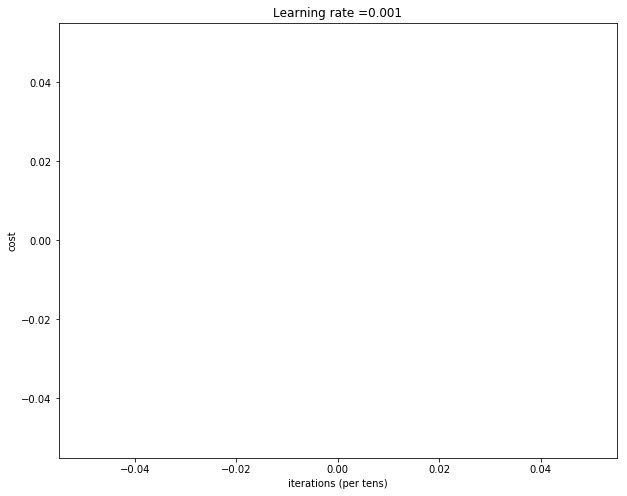

0

In [22]:
# Test Case

# input features
H = padded_proposals.astype(np.float32)

# input framstamps [f_init, f_end]
framestamps = padded_framestamps

# Indicators for past and future
Ipast = temporal_indicator(framestamps, mode="past").astype(np.float32)
Ifuture = temporal_indicator(framestamps, mode="future").astype(np.float32)

# Word Embedding Matrix
emb_matrix, word2id, id2word = get_wordvector(embedding_size,vocab_size,vocabulary) #changed by Songze

sentence_ids = all_padded_sentences_id
Ycaptions = copy.deepcopy(all_padded_sentences_2) 
Xcaptions = copy.deepcopy(all_padded_sentences)
Xcaptions = np.transpose(Xcaptions,axes=(0,2,1)).astype(np.int32)
Ycaptions = np.transpose(Ycaptions,axes=(0,2,1)).astype(np.int32)

learning_rate = 0.001
num_epochs = 5
model(H, Ipast, Ifuture, Ycaptions, Xcaptions,len(word2id), learning_rate, num_epochs)